In [1]:
using Distributions
using Random
using StatsPlots
default(fmt=:png, titlefontsize=12)

ecdf_(A, x) = count(≤(x), A) / length(A)

ecdf_ (generic function with 1 method)

In [2]:
function tvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ=0)
    (x̄ - ȳ - Δμ) / √(sx²/m + sy²/n)
end

function tvalue_welch(x, y; Δμ=0)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    tvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ)
end

function degree_of_freedom_welch(m, sx², n, sy²)
    (sx²/m + sy²/n)^2 / ((sx²/m)^2/(m-1) + (sy²/n)^2/(n-1))
end

function degree_of_freedom_welch(x, y)
    m, sx² = length(x), var(x)
    n, sy² = length(y), var(y)
    degree_of_freedom_welch(m, sx², n, sy²)
end

function pvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ=0)
    t = tvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ)
    ν = degree_of_freedom_welch(m, sx², n, sy²)
    2ccdf(TDist(ν), abs(t))
end

function pvalue_welch(x, y; Δμ=0)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    pvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ)
end

function confint_welch(m, x̄, sx², n, ȳ, sy²; α=0.05)
    ν = degree_of_freedom_welch(m, sx², n, sy²)
    c = quantile(TDist(ν), 1-α/2)
    SEhat = √(sx²/m + sy²/n)
    [x̄-ȳ-c*SEhat, x̄-ȳ+c*SEhat]
end

function confint_welch(x, y; α=0.05)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    confint_welch(m, x̄, sx², n, ȳ, sy²; α)
end

confint_welch (generic function with 2 methods)

In [3]:
s²_student(m, sx², n, sy²) = ((m-1)*sx² + (n-1)*sy²)/(m+n-2)

function tvalue_student(m, x̄, sx², n, ȳ, sy²; Δμ=0)
    s² = s²_student(m, sx², n, sy²)
    (x̄ - ȳ - Δμ) / √(s²*(1/m + 1/n))
end

function tvalue_student(x, y; Δμ=0)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    tvalue_student(m, x̄, sx², n, ȳ, sy²; Δμ)
end

function pvalue_student(m, x̄, sx², n, ȳ, sy²; Δμ=0)
    t = tvalue_student(m, x̄, sx², n, ȳ, sy²; Δμ)
    2ccdf(TDist(m+n-2), abs(t))
end

function pvalue_student(x, y; Δμ=0)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    pvalue_student(m, x̄, sx², n, ȳ, sy²; Δμ)
end

function confint_student(m, x̄, sx², n, ȳ, sy²; α=0.05)
    c = quantile(TDist(m+n-2), 1-α/2)
    s² = s²_student(m, sx², n, sy²)
    SEhat = √(s²*(1/m + 1/n))
    [x̄-ȳ-c*SEhat, x̄-ȳ+c*SEhat]
end

function confint_student(x, y; α=0.05)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    confint_student(m, x̄, sx², n, ȳ, sy²; α)
end

confint_student (generic function with 2 methods)

In [4]:
function sim_pvalues(;
        distx = Normal(0, 1),
        disty = Normal(0, 1),
        m = 50,
        n = 50,
        L = 10^5,
    )
    pval_s = zeros(L)
    pval_w = zeros(L)
    Xtmp = [zeros(m) for _ in 1:Threads.nthreads()]
    Ytmp = [zeros(n) for _ in 1:Threads.nthreads()]
    Threads.@threads :static for i in 1:L
        tid = Threads.threadid()
        X = rand!(distx, Xtmp[tid])
        Y = rand!(disty, Ytmp[tid])
        pval_s[i] = pvalue_student(X, Y)
        pval_w[i] = pvalue_welch(X, Y)
    end
    (; pval_s, pval_w)
end

function powers(;
        distx = Normal(0, 1),
        disty = Normal(0, 1),
        m = 50,
        n = 50,
        L = 10^5,
        α = 0.05,
    )
    (; pval_s, pval_w) = sim_pvalues(; distx, disty, m, n, L)
    power_s = ecdf_(pval_s, α)
    power_w = ecdf_(pval_w, α)
    (; power_s, power_w)
end

function plot_powers(;
        Δμ = 0.0,
        σratios = 1:1:10,
        xticks = σratios,
        m = 50,
        n = 50,
        L = 10^5,
        α = 0.05,
        kwargs...
    )
    powers_s = zeros(length(σratios))
    powers_w = zeros(length(σratios))
    for (i, σratio) in enumerate(σratios)
        distx = Normal(0, 1)
        disty = Normal(Δμ, σratio)
        (; power_s, power_w) = powers(; distx, disty, m, n, L, α)
        powers_s[i] = power_s
        powers_w[i] = power_w
    end
    plot(σratios, powers_s; marker=:o, ms=3, msc=:auto, label="Student")
    plot!(σratios, powers_w; marker=:star, msc=:auto, label="Welch", ls=:dash)
    plot!(; ylim=(-0.03, 1.03))
    plot!(; xticks, yticks=0:0.05:1)
    yguide = Δμ == 0 ? "α-error rate" : "power"
    plot!(; xguide="s₂/s₁", yguide)
    Δμstr = Δμ == 0 ? "0" : Δμ != 1 ? "$(Δμ)s₁" : "s₁"
    title!("Δμ=$Δμstr,  n₁=$m,  n₂=$n   (sim_iters=$L)")
    plot!(; kwargs...)
end

plot_powers (generic function with 1 method)

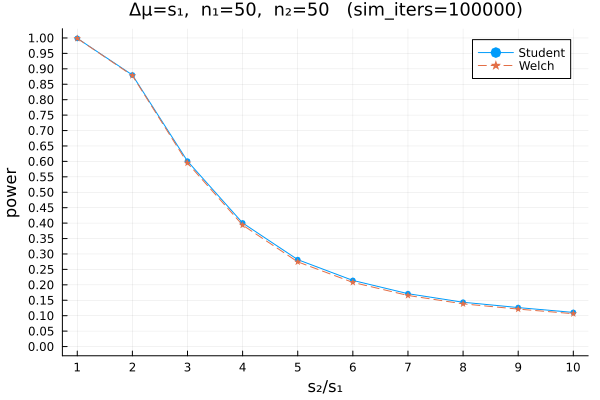

In [5]:
plot_powers(; Δμ=1)

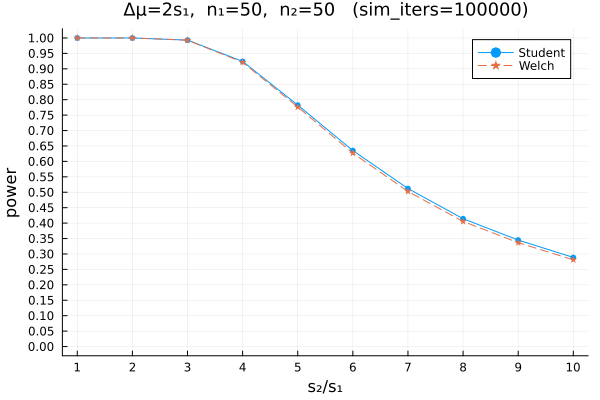

In [6]:
plot_powers(; Δμ=2)

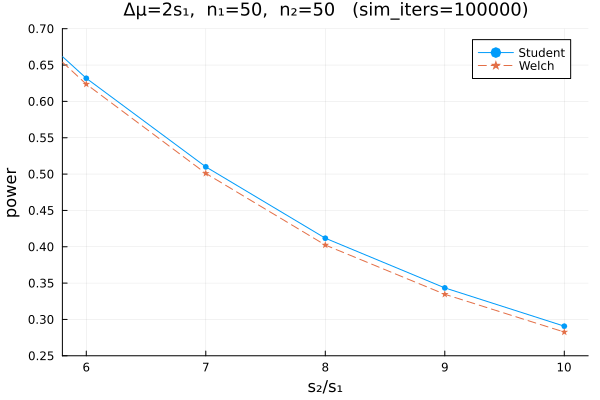

In [7]:
plot_powers(; Δμ=2, xlim=(5.8, 10.2), ylim=(0.25, 0.70))

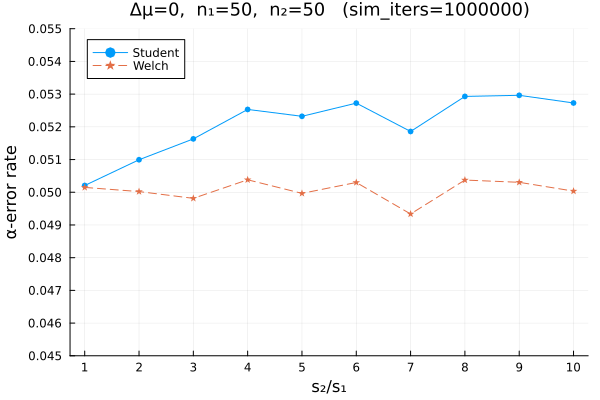

In [8]:
plot_powers(; Δμ=0, ylim=(0.045, 0.055), L=10^6, ytick=0:0.001:1)

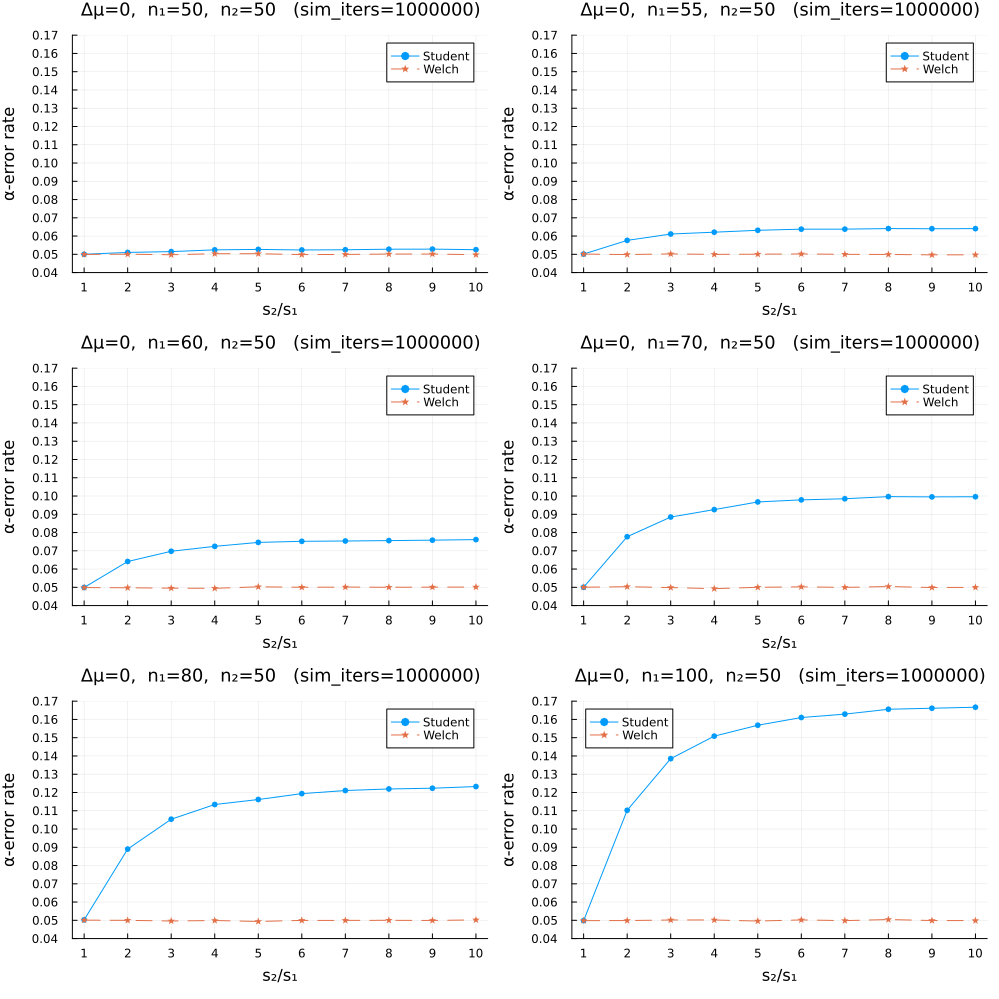

In [9]:
PP = []
for m in (50, 55, 60, 70, 80, 100)
    P = plot_powers(; Δμ=0, m, n=50, ylim=(0.04, 0.17), L=10^6, ytick=0:0.01:1)
    push!(PP, P)
end
plot(PP...; size=(1000, 1000), layout=(3, 2))

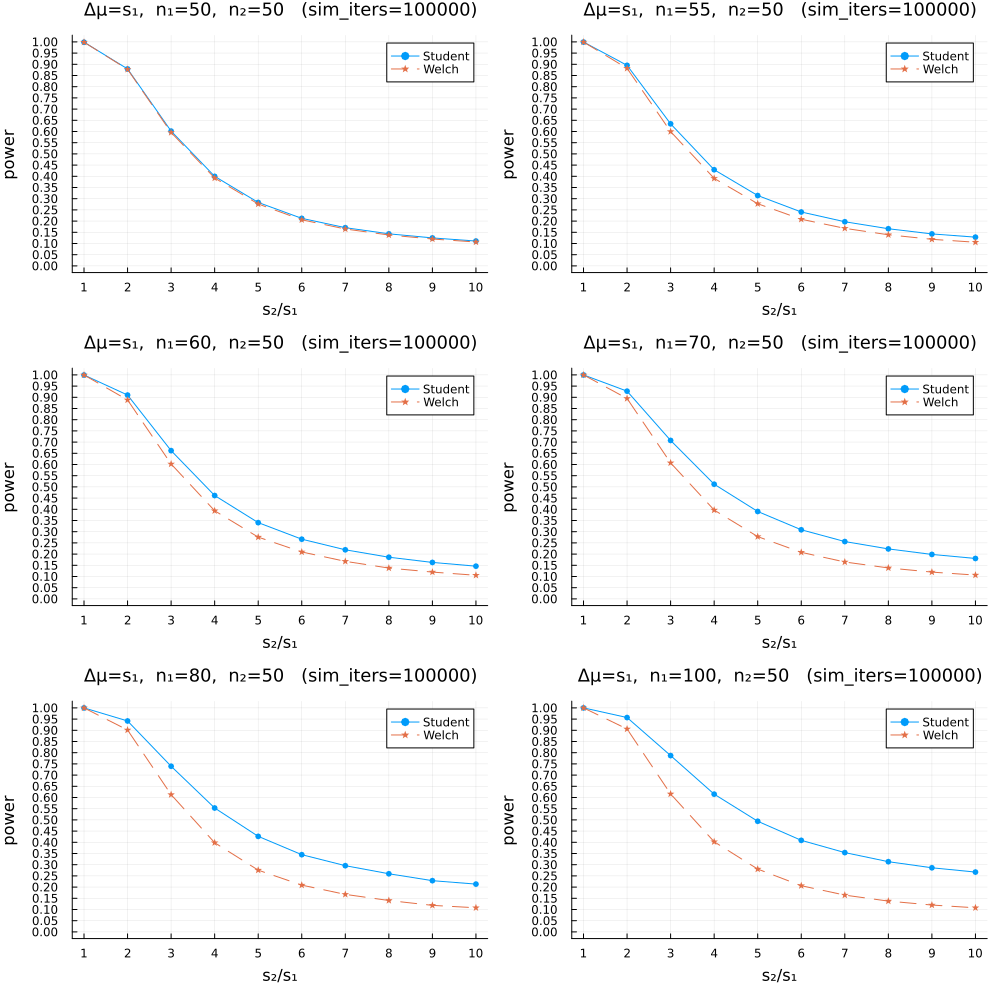

In [10]:
PP = []
for m in (50, 55, 60, 70, 80, 100)
    P = plot_powers(; Δμ=1, m, n=50)
    push!(PP, P)
end
plot(PP...; size=(1000, 1000), layout=(3, 2))

In [ ]:
PP = []
for n in (50, 55, 60, 70, 80, 100)
    P = plot_powers(; Δμ=0, m=50, n, ylim=(-0.002, 0.06), L=10^6, ytick=0:0.01:1)
    push!(PP, P)
end
plot(PP...; size=(1000, 1000), layout=(3, 2))

In [ ]:
PP = []
for n in (50, 55, 60, 70, 80, 100)
    P = plot_powers(; Δμ=1, m=50, n)
    push!(PP, P)
end
plot(PP...; size=(1000, 1000), layout=(3, 2))